In [37]:
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, concatenate

import warnings
warnings.filterwarnings('ignore')

In [38]:
df = pd.read_excel('energy_demand.xlsx')
print(df)


            Date  Hour    load          T
0     2012-01-01     0  2872.0  30.666667
1     2012-01-01     1  2698.0  32.000000
2     2012-01-01     2  2558.0  32.666667
3     2012-01-01     3  2444.0  30.000000
4     2012-01-01     4  2402.0  31.000000
...          ...   ...     ...        ...
26300 2014-12-31    20  4012.0  18.000000
26301 2014-12-31    21  3856.0  16.666667
26302 2014-12-31    22  3671.0  17.000000
26303 2014-12-31    23  3499.0  15.333333
26304 2014-12-31    24  3345.0  15.333333

[26305 rows x 4 columns]


In [39]:
# Convert to datetime, considering "24" as "0" of the next day
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Hour'].astype(str) + ':00:00', errors='coerce')

# Adjust the hour for values equal to 24 and increment the date
mask = df['Hour'] == 24
df.loc[mask, 'Datetime'] = pd.to_datetime(df.loc[mask, 'Date'].astype(str) + ' 00:00:00', errors='coerce') + pd.DateOffset(days=1)

# Drop the original columns if needed
df = df.drop(['Date', 'Hour'], axis=1)
df.set_index('Datetime', inplace=True)
print(df.head(300))

                       load          T
Datetime                              
2012-01-01 00:00:00  2872.0  30.666667
2012-01-01 01:00:00  2698.0  32.000000
2012-01-01 02:00:00  2558.0  32.666667
2012-01-01 03:00:00  2444.0  30.000000
2012-01-01 04:00:00  2402.0  31.000000
...                     ...        ...
2012-01-13 07:00:00  3418.0  30.000000
2012-01-13 08:00:00  3681.0  29.333333
2012-01-13 09:00:00  3768.0  29.333333
2012-01-13 10:00:00  3818.0  30.333333
2012-01-13 11:00:00  3856.0  30.666667

[300 rows x 2 columns]


## X-to-Y (Transform Data Series)

In [40]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]

        X.append(row)
        label = df_as_np[i+5]

        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_X_y(df['load'], 5)

print(X.shape)
print(y.shape)


(26300, 5, 1)
(26300,)


In [41]:
#train_val_test split

X, y = df_to_X_y(df['load'], 6)



split_train_ratio = 0.7
split_train_index = int(split_train_ratio * len(df))

split_val_ratio = 0.8
split_val_index = int(split_val_ratio * len(df))

# print(split_train_index)
# print(split_val_index)

X_train, y_train = X[:split_train_index], y[:split_train_index]
X_val, y_val = X[split_train_index:split_val_index], y[split_train_index:split_val_index]
X_test, y_test = X[split_val_index:], y[split_val_index:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(18413, 5, 1) (18413,)
(2631, 5, 1) (2631,)
(5255, 5, 1) (5255,)


In [42]:
# Reshape X to 2D for scaling (assuming X has shape: (samples, time_steps, features))
X_train_2D = X_train.reshape(-1, X_train.shape[-1])
X_val_2D = X_val.reshape(-1, X_val.shape[-1])
X_test_2D = X_test.reshape(-1, X_test.shape[-1])

# Scale input features (X)
scaler_X = MinMaxScaler()
X_train_scaled_2D = scaler_X.fit_transform(X_train_2D)
X_val_scaled_2D = scaler_X.transform(X_val_2D)
X_test_scaled_2D = scaler_X.transform(X_test_2D)

# Reshape X back to 3D after scaling
X_train_scaled = X_train_scaled_2D.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2D.reshape(X_val.shape)
X_test_scaled = X_test_scaled_2D.reshape(X_test.shape)

# Scale target variable (y)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [43]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val_scaled))

# Evaluate the model on the test set
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss: {test_loss}')

# Make predictions on the test set
y_pred_single_lstm_scaled = model.predict(X_test_scaled)

# Inverse transform the predicted values to the original scale
y_pred_single_lstm = scaler_y.inverse_transform(y_pred_single_lstm_scaled.reshape(-1, 1)).flatten()

Epoch 1/50
576/576 [==============================] - 4s 4ms/step - loss: 0.0109 - val_loss: 0.0020
Epoch 2/50
576/576 [==============================] - 2s 4ms/step - loss: 0.0015 - val_loss: 9.1709e-04
Epoch 3/50
576/576 [==============================] - 2s 4ms/step - loss: 7.6772e-04 - val_loss: 6.3595e-04
Epoch 4/50
576/576 [==============================] - 2s 4ms/step - loss: 5.9536e-04 - val_loss: 5.9885e-04
Epoch 5/50
576/576 [==============================] - 2s 4ms/step - loss: 5.3169e-04 - val_loss: 6.2288e-04
Epoch 6/50
576/576 [==============================] - 2s 4ms/step - loss: 5.2232e-04 - val_loss: 5.4725e-04
Epoch 7/50
576/576 [==============================] - 2s 4ms/step - loss: 5.1601e-04 - val_loss: 4.5484e-04
Epoch 8/50
576/576 [==============================] - 2s 4ms/step - loss: 4.8837e-04 - val_loss: 4.5322e-04
Epoch 9/50
576/576 [==============================] - 2s 4ms/step - loss: 5.0293e-04 - val_loss: 4.3403e-04
Epoch 10/50
576/576 [===================

Mean Squared Error (MSE): 3090.614375801216


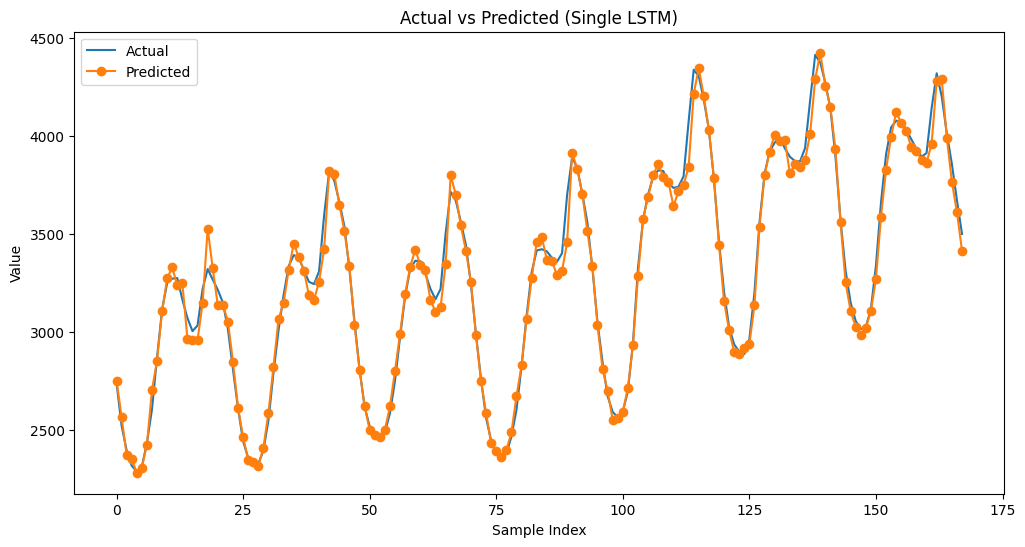

In [44]:
# Calculate Mean Squared Error (MSE)
mse_single_lstm = mean_squared_error(y_test, y_pred_single_lstm)
print(f'Mean Squared Error (MSE): {mse_single_lstm}')

mae_single_lstm = mean_absolute_error(y_test, y_pred_single_lstm)


# Plot the comparisons between the test and predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[-168:], label='Actual')
plt.plot(y_pred_single_lstm[-168:], label='Predicted', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted (Single LSTM)')
plt.legend()
plt.show()

### GRU

In [45]:
# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model_gru.add(Dense(units=25, activation='relu'))
model_gru.add(Dense(units=1))

# Compile the GRU model
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val_scaled))

# Evaluate the GRU model on the test set
test_loss_gru = model_gru.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss (GRU): {test_loss_gru}')

# Make predictions on the test set using the GRU model
y_pred_single_gru_scaled = model_gru.predict(X_test_scaled)

# Inverse transform the predicted values to the original scale
y_pred_single_gru = scaler_y.inverse_transform(y_pred_single_gru_scaled.reshape(-1, 1)).flatten()


Epoch 1/50
576/576 [==============================] - 5s 5ms/step - loss: 0.0091 - val_loss: 0.0014
Epoch 2/50
576/576 [==============================] - 2s 4ms/step - loss: 0.0011 - val_loss: 8.4304e-04
Epoch 3/50
576/576 [==============================] - 2s 4ms/step - loss: 7.1107e-04 - val_loss: 5.6303e-04
Epoch 4/50
576/576 [==============================] - 3s 4ms/step - loss: 5.8735e-04 - val_loss: 5.1048e-04
Epoch 5/50
576/576 [==============================] - 2s 4ms/step - loss: 5.3089e-04 - val_loss: 4.7365e-04
Epoch 6/50
576/576 [==============================] - 2s 4ms/step - loss: 4.9783e-04 - val_loss: 4.8089e-04
Epoch 7/50
576/576 [==============================] - 3s 4ms/step - loss: 4.9914e-04 - val_loss: 4.9331e-04
Epoch 8/50
576/576 [==============================] - 2s 4ms/step - loss: 4.9507e-04 - val_loss: 4.6686e-04
Epoch 9/50
576/576 [==============================] - 2s 4ms/step - loss: 4.8245e-04 - val_loss: 4.6333e-04
Epoch 10/50
576/576 [===================

Mean Squared Error (MSE) for GRU: 5617.343330634276


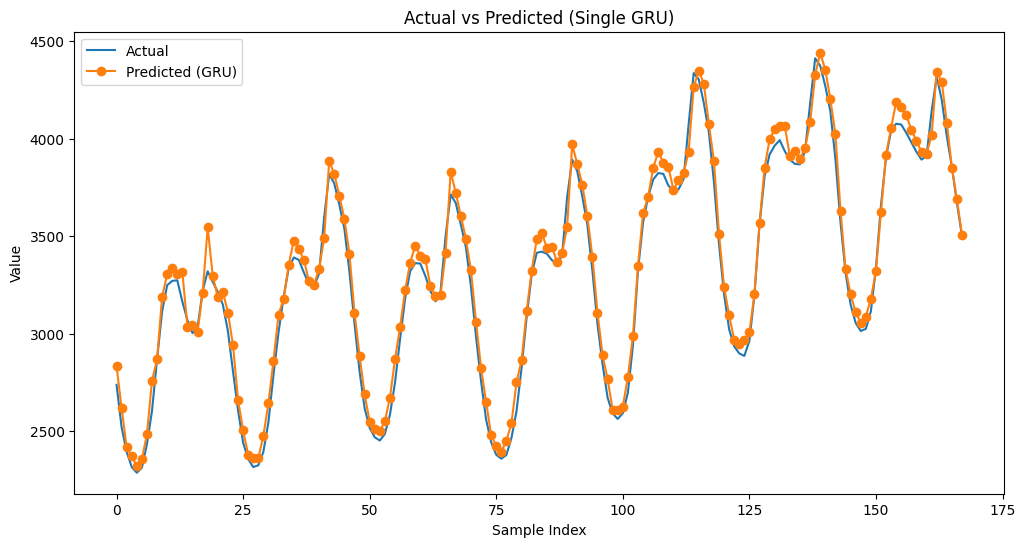

In [46]:
# Calculate Mean Squared Error (MSE) for GRU
mse_gru_single = mean_squared_error(y_test, y_pred_single_gru)
print(f'Mean Squared Error (MSE) for GRU: {mse_gru_single}')

mae_gru_single = mean_absolute_error(y_test, y_pred_single_gru)


# Plot the comparisons between the test and GRU predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[-168:], label='Actual')
plt.plot(y_pred_single_gru[-168:], label='Predicted (GRU)', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted (Single GRU)')
plt.legend()
plt.show()

# Multi-step

In [11]:
def df_to_X_y_multistep(df, window_size, horizon):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np) - window_size - horizon + 1):
        # Input sequence
        X.append(df_as_np[i:i+window_size])

        # Output sequence (horizon steps into the future)
        label = df_as_np[i+window_size:i+window_size+horizon]
        y.append(label)

    return np.array(X), np.array(y)

    
#train_val_test split

window = 8
horizon = 3

X, y = df_to_X_y_multistep(df['load'], window, horizon)


split_train_ratio = 0.7
split_train_index = int(split_train_ratio * len(df))

split_val_ratio = 0.8
split_val_index = int(split_val_ratio * len(df))

# print(split_train_index)
# print(split_val_index)

X_train, y_train = X[:split_train_index], y[:split_train_index]
X_val, y_val = X[split_train_index:split_val_index], y[split_train_index:split_val_index]
X_test, y_test = X[split_val_index:], y[split_val_index:]


# Reshape the data for deep learning models
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)



(18413, 8, 1) (18413, 3)
(2631, 8, 1) (2631, 3)
(5251, 8, 1) (5251, 3)


In [12]:
# Reshape X to 2D for scaling (assuming X has shape: (samples, time_steps, features))
X_train_2D = X_train.reshape(-1, X_train.shape[-1])
X_val_2D = X_val.reshape(-1, X_val.shape[-1])
X_test_2D = X_test.reshape(-1, X_test.shape[-1])

# Scale input features (X)
scaler_X = MinMaxScaler()
X_train_scaled_2D = scaler_X.fit_transform(X_train_2D)
X_val_scaled_2D = scaler_X.transform(X_val_2D)
X_test_scaled_2D = scaler_X.transform(X_test_2D)

# Reshape X back to 3D after scaling
X_train_scaled = X_train_scaled_2D.reshape(X_train.shape)
X_val_scaled = X_val_scaled_2D.reshape(X_val.shape)
X_test_scaled = X_test_scaled_2D.reshape(X_test.shape)

# Scale target variable (y)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)



print(y_train_scaled.shape)

(18413, 3)


### LSTM

In [13]:
# Create LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(window, 1)))
model.add(Dense(units=25, activation='relu'))
model_lstm.add(Dense(units=horizon))
model_lstm.compile(optimizer='adam', loss='mse')

# Train the model
history = model_lstm.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=2)

# Evaluate the model on the test set
test_loss = model_lstm.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss: {test_loss}')

# Make predictions on the test set
y_pred_multi_lstm_scaled = model_lstm.predict(X_test_scaled)

# Inverse transform the predicted values to the original scale
y_pred_multi_lstm = scaler_y.inverse_transform(y_pred_multi_lstm_scaled)

# Flatten the true labels and predictions for visualization
y_test_flattened = y_test.flatten()
y_pred_multi_lstm_multi = y_pred_multi_lstm.flatten()

# Calculate Mean Squared Error (MSE)
mse_multi_lstm = mean_squared_error(y_test_flattened, y_pred_multi_lstm_multi)
print(f'Mean Squared Error (MSE): {mse_multi_lstm}')


mae_multi_lstm = mean_absolute_error(y_test_flattened, y_pred_multi_lstm_multi)


Epoch 1/100
576/576 - 5s - loss: 0.0226 - val_loss: 0.0084 - 5s/epoch - 8ms/step
Epoch 2/100
576/576 - 3s - loss: 0.0061 - val_loss: 0.0044 - 3s/epoch - 4ms/step
Epoch 3/100
576/576 - 3s - loss: 0.0044 - val_loss: 0.0040 - 3s/epoch - 4ms/step
Epoch 4/100
576/576 - 3s - loss: 0.0037 - val_loss: 0.0035 - 3s/epoch - 4ms/step
Epoch 5/100
576/576 - 3s - loss: 0.0033 - val_loss: 0.0027 - 3s/epoch - 4ms/step
Epoch 6/100
576/576 - 3s - loss: 0.0030 - val_loss: 0.0021 - 3s/epoch - 4ms/step
Epoch 7/100
576/576 - 3s - loss: 0.0029 - val_loss: 0.0026 - 3s/epoch - 4ms/step
Epoch 8/100
576/576 - 3s - loss: 0.0028 - val_loss: 0.0022 - 3s/epoch - 4ms/step
Epoch 9/100
576/576 - 3s - loss: 0.0026 - val_loss: 0.0025 - 3s/epoch - 5ms/step
Epoch 10/100
576/576 - 3s - loss: 0.0026 - val_loss: 0.0019 - 3s/epoch - 6ms/step
Epoch 11/100
576/576 - 3s - loss: 0.0025 - val_loss: 0.0018 - 3s/epoch - 5ms/step
Epoch 12/100
576/576 - 3s - loss: 0.0024 - val_loss: 0.0017 - 3s/epoch - 4ms/step
Epoch 13/100
576/576 - 3s

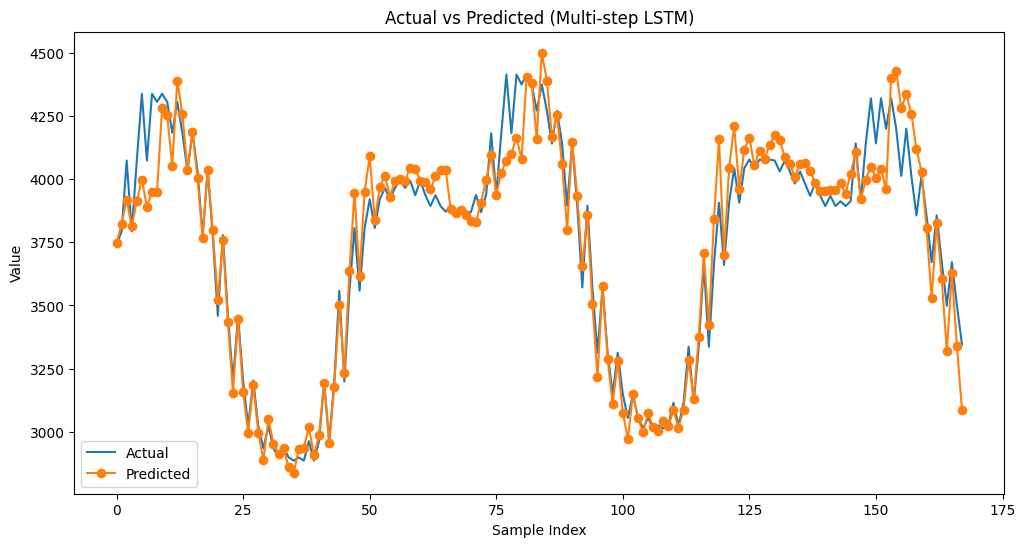

In [14]:
# Plot the comparisons between the test and predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_flattened[-168:], label='Actual')
plt.plot(y_pred_multi_lstm_multi[-168:], label='Predicted', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted (Multi-step LSTM)')
plt.legend()
plt.show()



### GRU

In [15]:
# GRU model with improvements
model_gru = Sequential()
model_gru.add(GRU(units=50, activation='relu', input_shape=(window, 1)))
model.add(Dense(units=25, activation='relu'))
model_gru.add(Dense(units=horizon))
model_gru.compile(optimizer='adam', loss='mse')

# Train the GRU model
model_gru.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val_scaled))

# Evaluate the GRU model on the test set
test_loss_gru = model_gru.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss (GRU): {test_loss_gru}')

# Make predictions on the test set using the GRU model
y_pred_multi_gru_scaled = model_gru.predict(X_test_scaled)

# Inverse transform the predicted values to the original scale
y_pred_multi_gru = scaler_y.inverse_transform(y_pred_multi_gru_scaled)

# Flatten the true labels and predictions for visualization
y_test_flattened = y_test.flatten()
y_pred_multi_gru_flattened = y_pred_multi_gru.flatten()

# Calculate Mean Squared Error (MSE)
mse_gru_multi = mean_squared_error(y_test_flattened, y_pred_multi_gru_flattened)
print(f'Mean Squared Error (GRU): {mse_gru_multi}')


mae_gru_multi = mean_absolute_error(y_test_flattened, y_pred_multi_gru_flattened)


Epoch 1/50
576/576 [==============================] - 5s 5ms/step - loss: 0.0193 - val_loss: 0.0062
Epoch 2/50
576/576 [==============================] - 3s 5ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 3/50
576/576 [==============================] - 3s 5ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 4/50
576/576 [==============================] - 3s 5ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 5/50
576/576 [==============================] - 3s 5ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 6/50
576/576 [==============================] - 3s 5ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 7/50
576/576 [==============================] - 3s 5ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 8/50
576/576 [==============================] - 3s 5ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9/50
576/576 [==============================] - 3s 5ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 10/50
576/576 [==============================] - 3s 5ms/step - loss: 0.0022 - val_loss: 0.0017

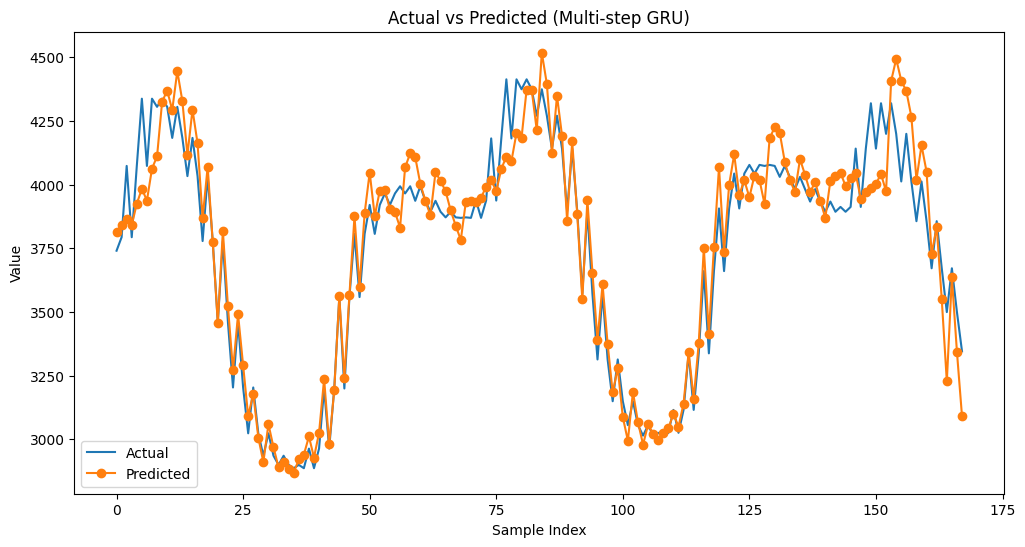

In [16]:
# Plot the comparisons between the test and predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_flattened[-168:], label='Actual')
plt.plot(y_pred_multi_gru_flattened[-168:], label='Predicted', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted (Multi-step GRU)')
plt.legend()
plt.show()

# Multivariate


## Single


In [17]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X_load = []
    X_temp = []
    y = []

    for i in range(len(df_as_np)-window_size):
        load_window = df_as_np[i:i+window_size, 0]  # Assuming 'load' is the first column
        temp_window = df_as_np[i:i+window_size, 1]  # Assuming 'T' is the second column

        X_load.append([[a] for a in load_window])
        X_temp.append([[a] for a in temp_window])

        label = df_as_np[i+window_size, 0]  # Assuming 'load' is the column to predict

        y.append(label)

    return np.array(X_load), np.array(X_temp), np.array(y)

# Assuming df is your DataFrame with 'load' and 'T' columns
X_load, X_temp, y = df_to_X_y(df[['load', 'T']], window_size=5)

print(X_load.shape)
print(X_temp.shape)
print(y.shape)

(26300, 5, 1)
(26300, 5, 1)
(26300,)


In [18]:
# Assuming X_load, X_temp, and y are obtained using the modified df_to_X_y function
X = {'load_input': X_load, 'temp_input': X_temp}
y = y

# Combine load and temperature into one array
X_combined = np.concatenate([X['load_input'], X['temp_input']], axis=-1)

# Reshape to (num_samples * timesteps, num_features)
X_combined_flat = X_combined.reshape(-1, X_combined.shape[-1])

# Scale the entire dataset
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale input features and target variable
X_scaled_flat = scaler_X.fit_transform(X_combined_flat)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Reshape back to original shape
X_scaled = X_scaled_flat.reshape(X_combined.shape)

# Perform sequential train/val/test split on the scaled data
# (adapt as needed based on your splitting method)
train_size = int(0.7 * len(X_scaled))
val_size = int(0.1 * len(X_scaled))

X_train_scaled, y_train_scaled = X_scaled[:train_size], y_scaled[:train_size]
X_val_scaled, y_val_scaled = X_scaled[train_size:train_size + val_size], y_scaled[train_size:train_size + val_size]
X_test_scaled, y_test_scaled = X_scaled[train_size + val_size:], y_scaled[train_size + val_size:]

# Print the shapes to verify
print("Train Shapes:")
print(X_train_scaled.shape, y_train_scaled.shape)
print("Validation Shapes:")
print(X_val_scaled.shape, y_val_scaled.shape)
print("Test Shapes:")
print(X_test_scaled.shape, y_test_scaled.shape)

Train Shapes:
(18410, 5, 2) (18410, 1)
Validation Shapes:
(2630, 5, 2) (2630, 1)
Test Shapes:
(5260, 5, 2) (5260, 1)


### LSTM (Multivariate)

In [19]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val_scaled))

# Make predictions on the test set
y_pred_multivariate_LSTM_scaled = model.predict(X_test_scaled)

# Invert the scaling for comparison if necessary
y_test_original = scaler_y.inverse_transform(y_test_scaled)
y_pred_single_multivariate_LSTM_original = scaler_y.inverse_transform(y_pred_multivariate_LSTM_scaled)

# Calculate MSE
mse_single_multivariate_LSTM = mean_squared_error(y_test_original, y_pred_single_multivariate_LSTM_original)
print("Multivariate LSTM Test MSE:", mse_single_multivariate_LSTM)



mae_single_multivariate_LSTM = mean_absolute_error(y_test_original, y_pred_single_multivariate_LSTM_original)


Epoch 1/50
576/576 [==============================] - 5s 5ms/step - loss: 0.0084 - val_loss: 0.0015
Epoch 2/50
576/576 [==============================] - 2s 4ms/step - loss: 0.0013 - val_loss: 8.5776e-04
Epoch 3/50
576/576 [==============================] - 2s 4ms/step - loss: 7.4896e-04 - val_loss: 5.1641e-04
Epoch 4/50
576/576 [==============================] - 2s 4ms/step - loss: 5.9100e-04 - val_loss: 4.6771e-04
Epoch 5/50
576/576 [==============================] - 3s 4ms/step - loss: 5.3261e-04 - val_loss: 5.2339e-04
Epoch 6/50
576/576 [==============================] - 2s 4ms/step - loss: 4.9775e-04 - val_loss: 5.1515e-04
Epoch 7/50
576/576 [==============================] - 2s 4ms/step - loss: 4.9448e-04 - val_loss: 3.9308e-04
Epoch 8/50
576/576 [==============================] - 2s 4ms/step - loss: 4.4257e-04 - val_loss: 3.5566e-04
Epoch 9/50
576/576 [==============================] - 2s 4ms/step - loss: 4.2800e-04 - val_loss: 3.4574e-04
Epoch 10/50
576/576 [===================

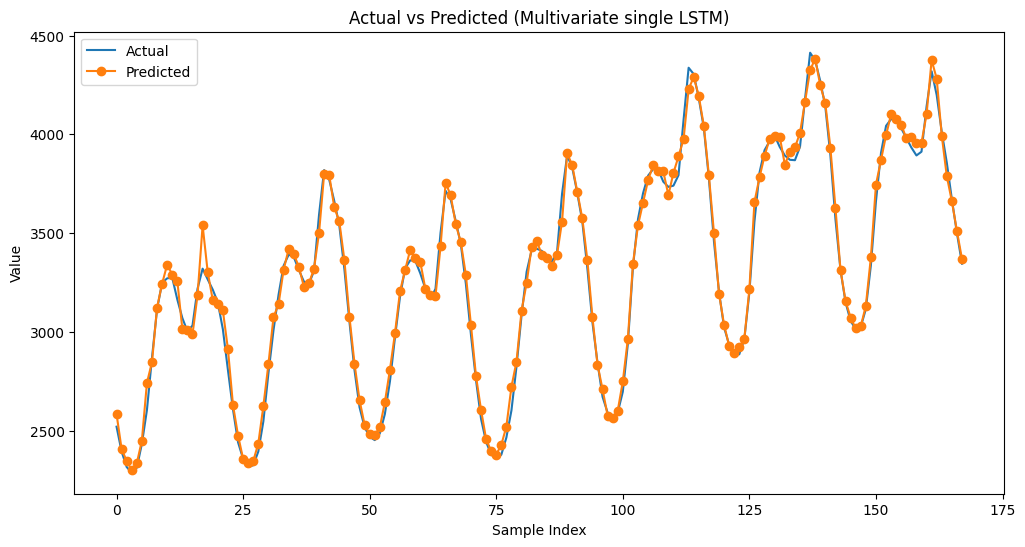

In [20]:


# Plot the comparisons between the test and predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[-168:], label='Actual')
plt.plot(y_pred_single_multivariate_LSTM_original[-168:], label='Predicted', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted (Multivariate single LSTM)')
plt.legend()
plt.show()

### GRU (Multivariate)

In [21]:
# Define the GRU model
model_gru = Sequential()
model_gru.add(GRU(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model_gru.add(Dense(units=25, activation='relu'))

model_gru.add(Dense(1))

# Compile the model
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_gru.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val_scaled))

# Make predictions on the test set
y_pred_multivariate_gru = model_gru.predict(X_test_scaled)

# Invert the scaling for comparison if necessary
y_test_original = scaler_y.inverse_transform(y_test_scaled)
y_pred_single_multivariate_gru_original = scaler_y.inverse_transform(y_pred_multivariate_gru)

# Calculate MSE
mse_single_multivariate_gru = mean_squared_error(y_test_original, y_pred_single_multivariate_gru_original)
print("Multivariate LSTM Test MSE:", mse_single_multivariate_gru)


mae_single_multivariate_gru = mean_absolute_error(y_test_original, y_pred_single_multivariate_gru_original)


Epoch 1/50
576/576 [==============================] - 5s 5ms/step - loss: 0.0052 - val_loss: 0.0010
Epoch 2/50
576/576 [==============================] - 2s 4ms/step - loss: 8.8243e-04 - val_loss: 6.6326e-04
Epoch 3/50
576/576 [==============================] - 2s 4ms/step - loss: 6.7300e-04 - val_loss: 5.9803e-04
Epoch 4/50
576/576 [==============================] - 2s 4ms/step - loss: 6.2956e-04 - val_loss: 5.4170e-04
Epoch 5/50
576/576 [==============================] - 2s 4ms/step - loss: 5.5842e-04 - val_loss: 4.5718e-04
Epoch 6/50
576/576 [==============================] - 2s 4ms/step - loss: 5.3861e-04 - val_loss: 7.0484e-04
Epoch 7/50
576/576 [==============================] - 2s 4ms/step - loss: 5.1730e-04 - val_loss: 4.1522e-04
Epoch 8/50
576/576 [==============================] - 2s 4ms/step - loss: 4.6888e-04 - val_loss: 5.8015e-04
Epoch 9/50
576/576 [==============================] - 2s 4ms/step - loss: 4.5804e-04 - val_loss: 4.3393e-04
Epoch 10/50
576/576 [===============

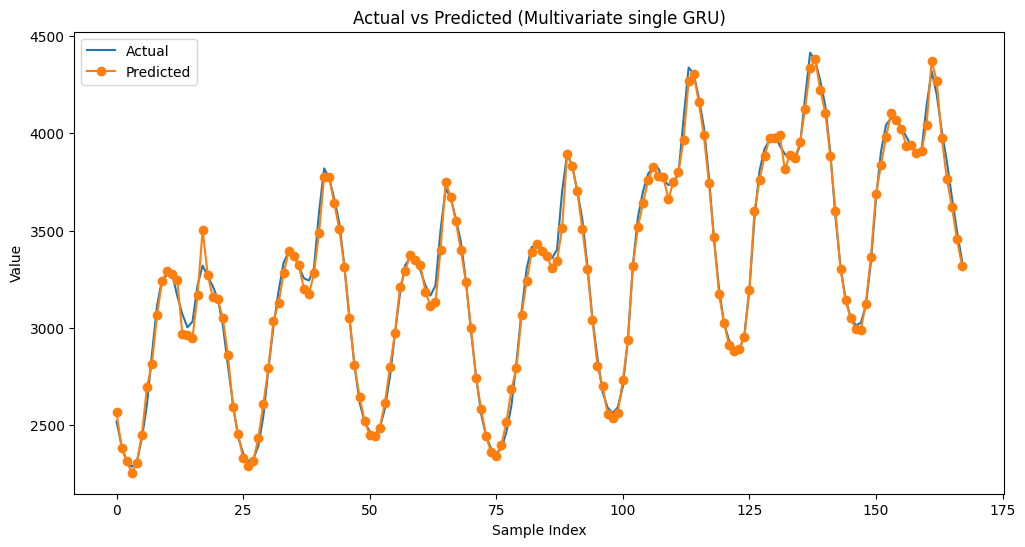

In [22]:


# Plot the comparisons between the test and predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[-168:], label='Actual')
plt.plot(y_pred_single_multivariate_gru_original[-168:], label='Predicted', marker='o')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted (Multivariate single GRU)')
plt.legend()
plt.show()

## Multistep

In [23]:
def df_to_X_y_multistep(df, window_size, horizon):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np) - window_size - horizon + 1):
        # Input sequence
        load_sequence = df_as_np[i:i+window_size, 0]  # Assuming 'load' is the first column
        temp_sequence = df_as_np[i:i+window_size, 1]  # Assuming 'T' is the second column
        input_sequence = np.column_stack((load_sequence, temp_sequence))
        X.append(input_sequence)

        # Output sequence (horizon steps into the future)
        label = df_as_np[i+window_size:i+window_size+horizon, 0]  # Assuming 'load' is the first column
        y.append(label)

    return np.array(X), np.array(y)


window = 8
horizon = 3

X, y = df_to_X_y_multistep(df[['load', 'T']], window, horizon)

print(X.shape)
print(y.shape)

(26295, 8, 2)
(26295, 3)


In [24]:
# Scale the input features
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).reshape(y.shape)

# Perform sequential train/val/test split
train_size = int(0.7 * len(X_scaled))
val_size = int(0.1 * len(X_scaled))

X_train, y_train = X_scaled[:train_size], y_scaled[:train_size]
X_val, y_val = X_scaled[train_size:train_size + val_size], y_scaled[train_size:train_size + val_size]
X_test, y_test = X_scaled[train_size + val_size:], y_scaled[train_size + val_size:]

# Print the shapes to verify
print("Train Shapes:")
print(X_train.shape, y_train.shape)
print("Validation Shapes:")
print(X_val.shape, y_val.shape)
print("Test Shapes:")
print(X_test.shape, y_test.shape)

Train Shapes:
(18406, 8, 2) (18406, 3)
Validation Shapes:
(2629, 8, 2) (2629, 3)
Test Shapes:
(5260, 8, 2) (5260, 3)


In [25]:
# Define the LSTM model with a middle layer
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(25, activation='relu'))  # Middle LSTM layer
    model.add(Dense(units=horizon))  # Output layer with units equal to the horizon
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the LSTM model
lstm_model = create_lstm_model(X_train.shape[1:])
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Make predictions on the test set
y_pred_lstm = lstm_model.predict(X_test)

# Invert the scaling for comparison if necessary
y_test_original = scaler.inverse_transform(y_test)
y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm)



Epoch 1/50
576/576 [==============================] - 7s 8ms/step - loss: 0.0231 - val_loss: 0.0070
Epoch 2/50
576/576 [==============================] - 4s 7ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 3/50
576/576 [==============================] - 4s 7ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/50
576/576 [==============================] - 4s 7ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/50
576/576 [==============================] - 4s 7ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 6/50
576/576 [==============================] - 4s 7ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 7/50
576/576 [==============================] - 4s 8ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/50
576/576 [==============================] - 4s 8ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/50
576/576 [==============================] - 4s 7ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 10/50
576/576 [==============================] - 4s 7ms/step - loss: 0.0021 - val_loss: 0.0018

LSTM Overall Test MSE: 7110.959518217666


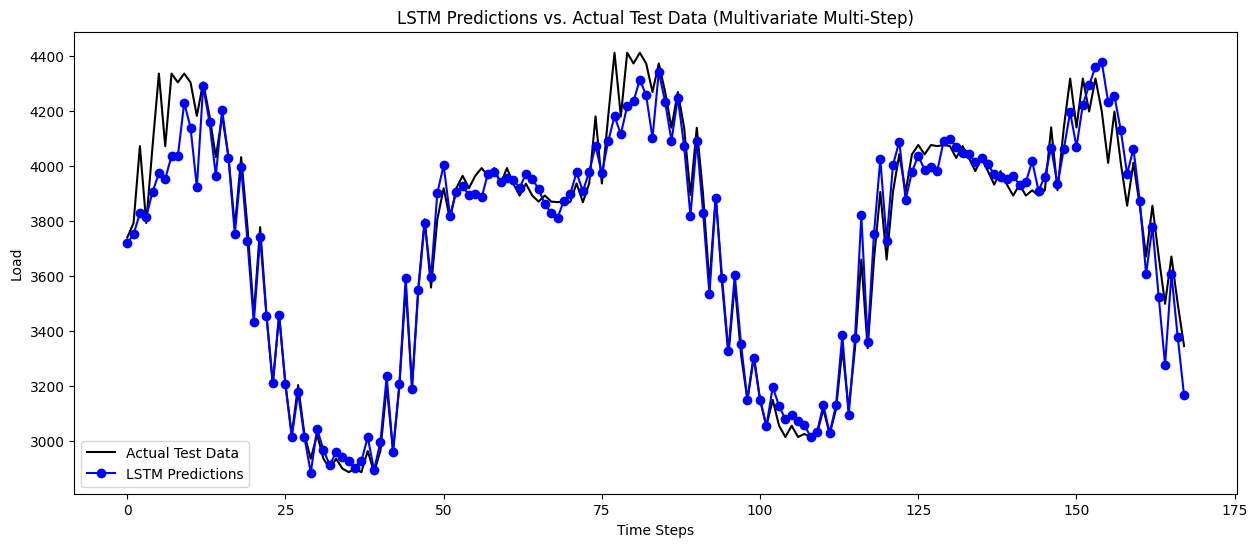

In [26]:

y_test_original = y_test_original.flatten()
y_pred__multi_multivariate_lstm_original = y_pred_lstm_original.flatten()

# Calculate overall MSE
mse__multi_multivariate_lstm_overall = mean_squared_error(y_test_original, y_pred__multi_multivariate_lstm_original)


mae_multi_multivariate_lstm_overall = mean_absolute_error(y_test_original, y_pred__multi_multivariate_lstm_original)

# Print overall MSE
print("LSTM Overall Test MSE:", mse__multi_multivariate_lstm_overall)

# Plot the flattened predictions in contrast to the flattened test data
plt.figure(figsize=(15, 6))

plt.plot(y_test_original[-168:], label='Actual Test Data', color='black')
plt.plot(y_pred__multi_multivariate_lstm_original[-168:], label='LSTM Predictions', marker='o', color='blue')

# Customize the plot
plt.title('LSTM Predictions vs. Actual Test Data (Multivariate Multi-Step)')
plt.xlabel('Time Steps')
plt.ylabel('Load')
plt.legend()
plt.show()

### GRU (Multivariate multistep)

In [27]:
# Define the GRU model with a middle layer
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(GRU(25, activation='relu'))  # Middle GRU layer
    model.add(Dense(units=horizon))  # Output layer with units equal to the horizon
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the GRU model
gru_model = create_gru_model(X_train.shape[1:])
gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Make predictions on the test set
y_pred_gru = gru_model.predict(X_test)

# Invert the scaling for comparison if necessary
y_pred_gru_original = scaler.inverse_transform(y_pred_gru)



Epoch 1/50
576/576 [==============================] - 8s 8ms/step - loss: 0.0141 - val_loss: 0.0045
Epoch 2/50
576/576 [==============================] - 4s 7ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 3/50
576/576 [==============================] - 5s 8ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/50
576/576 [==============================] - 5s 8ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/50
576/576 [==============================] - 4s 8ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 6/50
576/576 [==============================] - 4s 8ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 7/50
576/576 [==============================] - 4s 8ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 8/50
576/576 [==============================] - 4s 8ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 9/50
576/576 [==============================] - 4s 8ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 10/50
576/576 [==============================] - 4s 7ms/step - loss: 0.0019 - val_loss: 0.0017

GRU Test MSE: 5747.056787326645


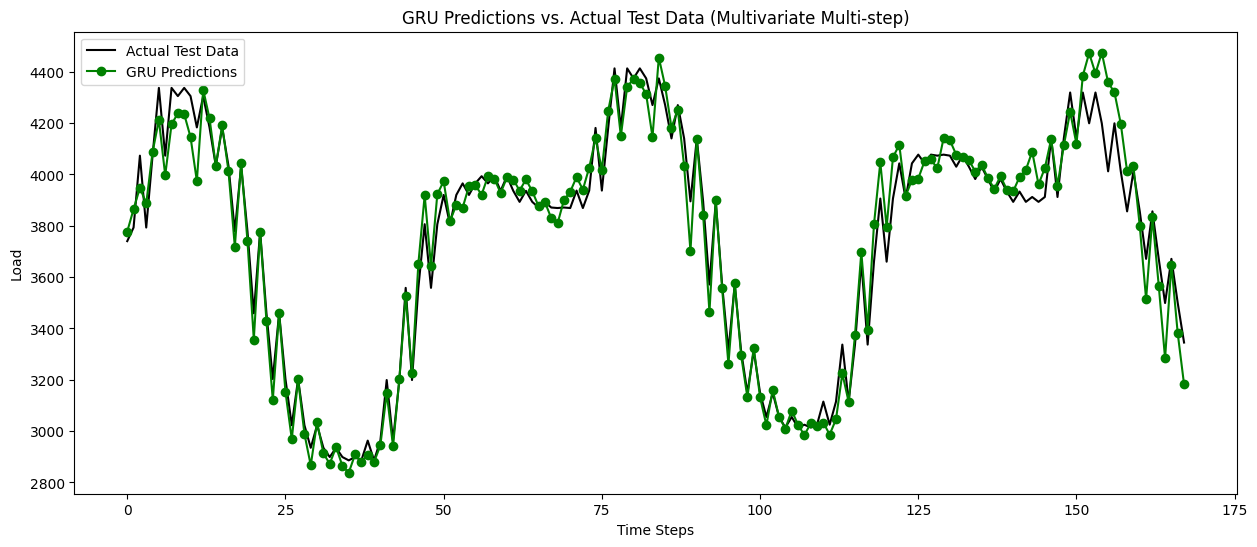

In [28]:
y_test_original = y_test_original.flatten()
y_pred__multi_multivariate_gru_original = y_pred_gru_original.flatten()


# Calculate MSE
mse__multi_multivariate_gru = mean_squared_error(y_test_original, y_pred__multi_multivariate_gru_original)
print("GRU Test MSE:", mse__multi_multivariate_gru)

mae_multi_multivariate_gru = mean_absolute_error(y_test_original, y_pred__multi_multivariate_gru_original)
# Plot the predictions in contrast to the test data
plt.figure(figsize=(15, 6))

# Plot the actual test data
plt.plot(y_test_original[-168:], label='Actual Test Data', color='black')
plt.plot(y_pred__multi_multivariate_gru_original[-168:], label='GRU Predictions', marker='o', color='green')

# Customize the plot
plt.title('GRU Predictions vs. Actual Test Data (Multivariate Multi-step)')
plt.xlabel('Time Steps')
plt.ylabel('Load')
plt.legend()
plt.show()

# Model evaluation (MSE/MAE/RMSE Comparison)

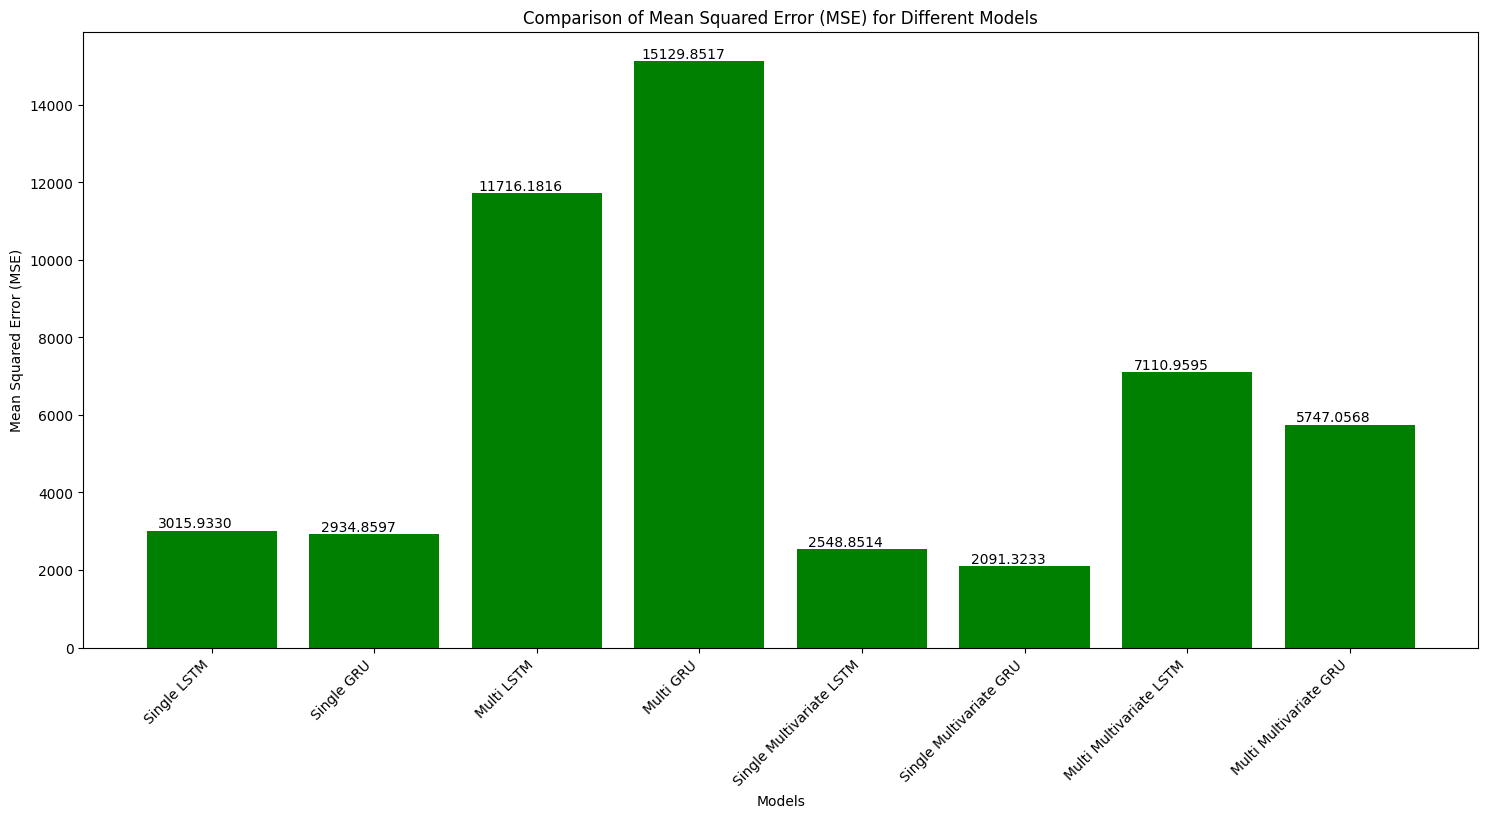

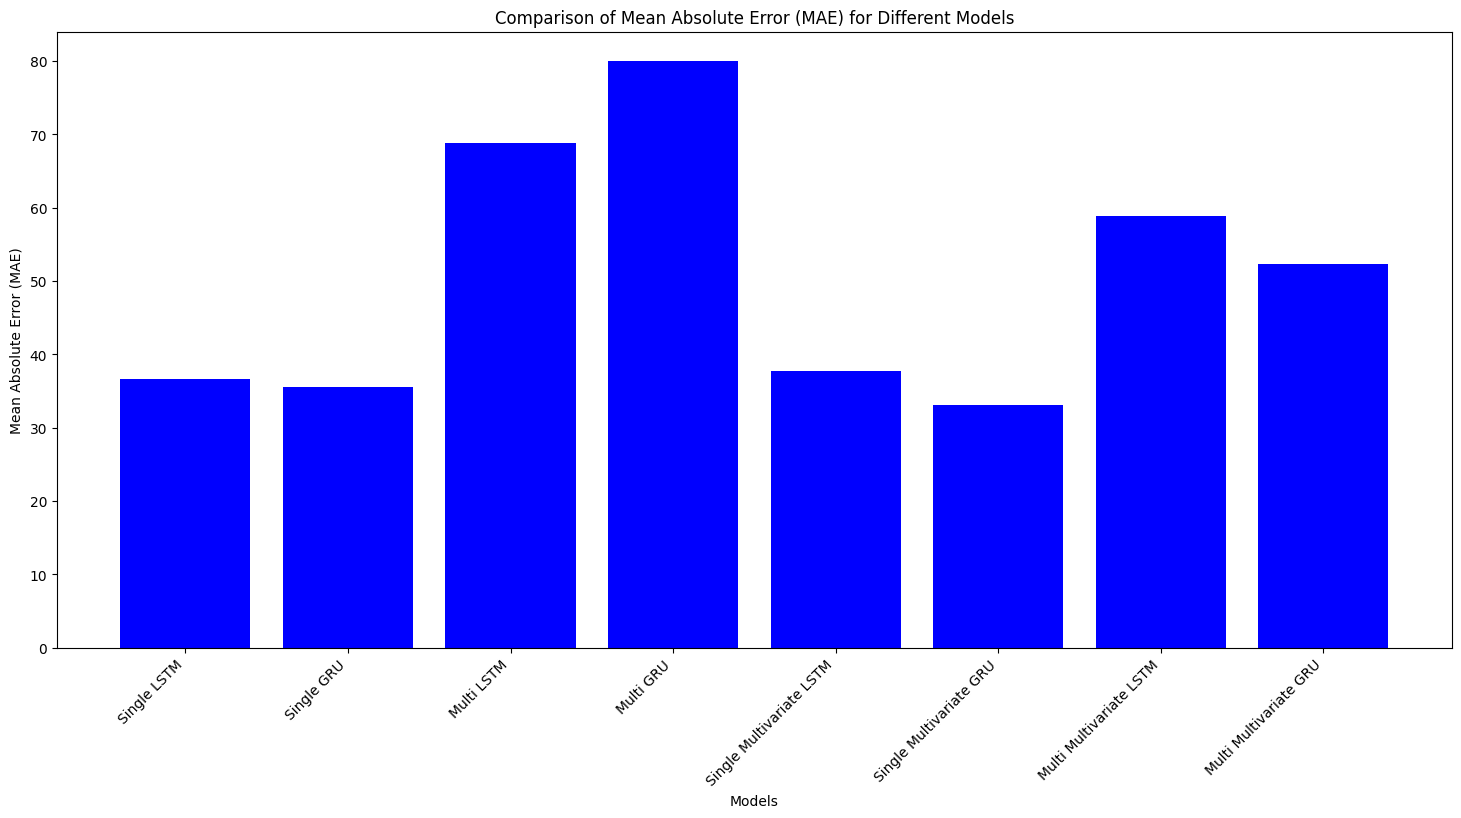

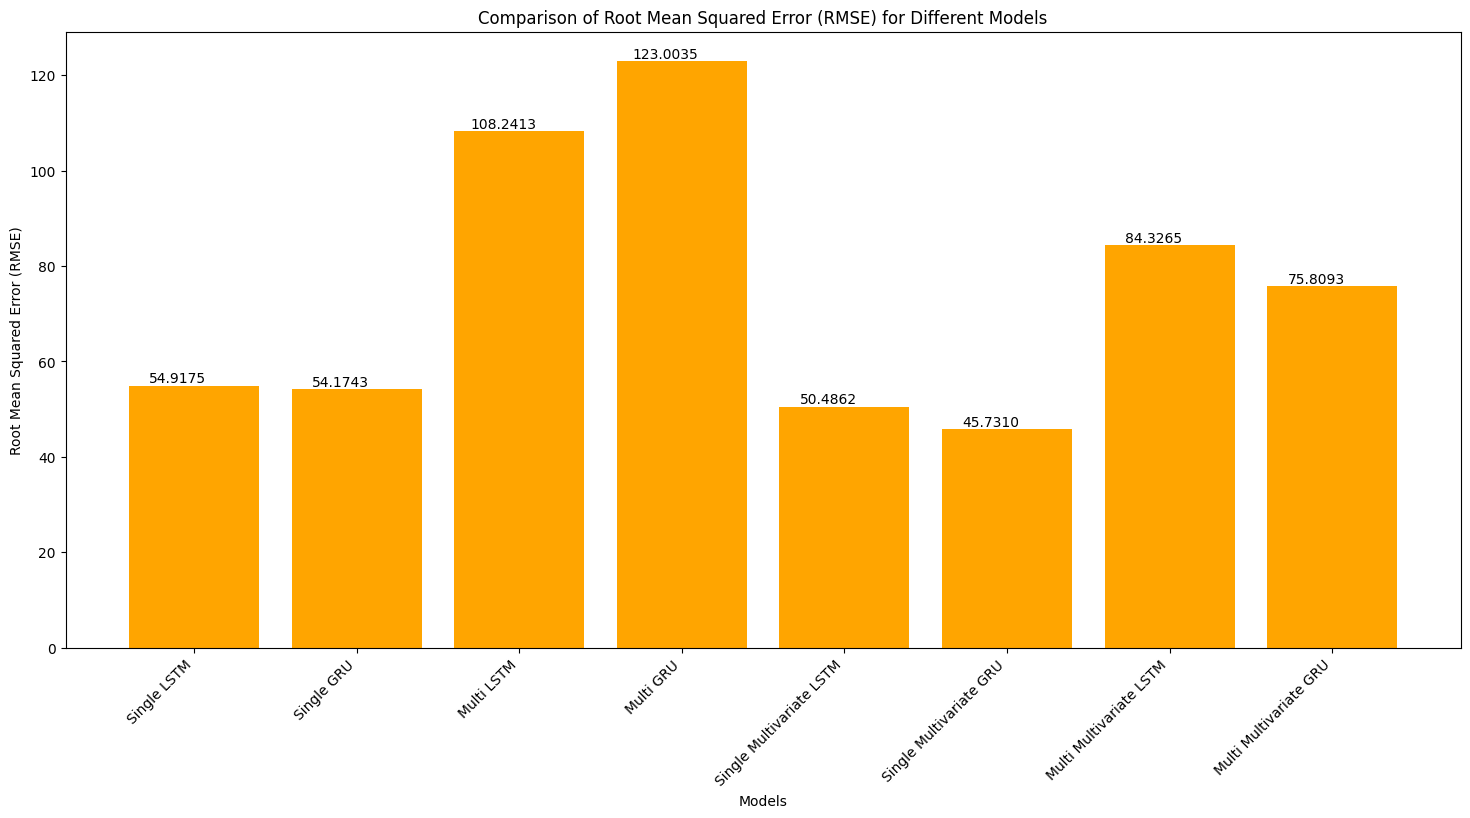

Model: Single LSTM
Mean Squared Error (MSE): 3015.9330
Mean Absolute Error (MAE): 36.6785
Root Mean Squared Error (RMSE): 54.9175


Model: Single GRU
Mean Squared Error (MSE): 2934.8597
Mean Absolute Error (MAE): 35.5871
Root Mean Squared Error (RMSE): 54.1743


Model: Multi LSTM
Mean Squared Error (MSE): 11716.1816
Mean Absolute Error (MAE): 68.8112
Root Mean Squared Error (RMSE): 108.2413


Model: Multi GRU
Mean Squared Error (MSE): 15129.8517
Mean Absolute Error (MAE): 80.0424
Root Mean Squared Error (RMSE): 123.0035


Model: Single Multivariate LSTM
Mean Squared Error (MSE): 2548.8514
Mean Absolute Error (MAE): 37.7093
Root Mean Squared Error (RMSE): 50.4862


Model: Single Multivariate GRU
Mean Squared Error (MSE): 2091.3233
Mean Absolute Error (MAE): 33.1246
Root Mean Squared Error (RMSE): 45.7310


Model: Multi Multivariate LSTM
Mean Squared Error (MSE): 7110.9595
Mean Absolute Error (MAE): 58.8934
Root Mean Squared Error (RMSE): 84.3265


Model: Multi Multivariate GRU
Mean Squa

In [35]:

# # Single-step MSE values
# mse_single_lstm = mean_squared_error(y_test, y_pred_single_lstm)
# mse_gru_single = mean_squared_error(y_test, y_pred_single_gru)

# # Multi-step MSE values
# mse_multi_lstm = mean_squared_error(y_test_flattened, y_pred_multi_lstm_multi)
# mse_gru_multi = mean_squared_error(y_test_flattened, y_pred_multi_gru_flattened)

# # Multi-variate Single-step MSE values
# mse_single_multivariate_LSTM = mean_squared_error(y_test_original, y_pred_single_multivariate_LSTM_original)
# mse_single_multivariate_gru = mean_squared_error(y_test_original, y_pred_single_multivariate_gru_original)

# # Multi-variate Multi-step MSE values
# mse_multi_multivariate_lstm_overall = mean_squared_error(y_test_original, y_pred__multi_multivariate_lstm_original)
# mse_multi_multivariate_gru = mean_squared_error(y_test_original, y_pred__multi_multivariate_gru_original)

# # Calculate MAE for each model
# mae_single_lstm = mean_absolute_error(y_test, y_pred_single_lstm)
# mae_gru_single = mean_absolute_error(y_test, y_pred_single_gru)
# mae_multi_lstm = mean_absolute_error(y_test_flattened, y_pred_multi_lstm_multi)
# mae_gru_multi = mean_absolute_error(y_test_flattened, y_pred_multi_gru_flattened)
# mae_single_multivariate_LSTM = mean_absolute_error(y_test_original, y_pred_single_multivariate_LSTM_original)
# mae_single_multivariate_gru = mean_absolute_error(y_test_original, y_pred_single_multivariate_gru_original)
# mae_multi_multivariate_lstm_overall = mean_absolute_error(y_test_original, y_pred__multi_multivariate_lstm_original)
# mae_multi_multivariate_gru = mean_absolute_error(y_test_original, y_pred__multi_multivariate_gru_original)

# Calculate RMSE for each model
rmse_single_lstm = np.sqrt(mse_single_lstm)
rmse_gru_single = np.sqrt(mse_gru_single)
rmse_multi_lstm = np.sqrt(mse_multi_lstm)
rmse_gru_multi = np.sqrt(mse_gru_multi)
rmse_single_multivariate_LSTM = np.sqrt(mse_single_multivariate_LSTM)
rmse_single_multivariate_gru = np.sqrt(mse_single_multivariate_gru)
rmse_multi_multivariate_lstm_overall = np.sqrt(mse__multi_multivariate_lstm_overall)
rmse_multi_multivariate_gru = np.sqrt(mse__multi_multivariate_gru)

# Models list
models = ['Single LSTM', 'Single GRU', 'Multi LSTM', 'Multi GRU',
          'Single Multivariate LSTM', 'Single Multivariate GRU',
          'Multi Multivariate LSTM', 'Multi Multivariate GRU']

# MSE values list
mse_values = [mse_single_lstm, mse_gru_single, mse_multi_lstm, mse_gru_multi,
              mse_single_multivariate_LSTM, mse_single_multivariate_gru,
              mse__multi_multivariate_lstm_overall, mse__multi_multivariate_gru]

# MAE values list
mae_values = [mae_single_lstm, mae_gru_single, mae_multi_lstm, mae_gru_multi,
              mae_single_multivariate_LSTM, mae_single_multivariate_gru,
              mae_multi_multivariate_lstm_overall, mae_multi_multivariate_gru]

# RMSE values list
rmse_values = [rmse_single_lstm, rmse_gru_single, rmse_multi_lstm, rmse_gru_multi,
               rmse_single_multivariate_LSTM, rmse_single_multivariate_gru,
               rmse_multi_multivariate_lstm_overall, rmse_multi_multivariate_gru]

# Plot a bar plot for MSE
plt.figure(figsize=(18, 8))
bars = plt.bar(models, mse_values, color='green')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) for Different Models')
# Rotate model names diagonally
plt.xticks(rotation=45, ha='right')
# Add MSE values on top of the bars
for bar, value in zip(bars, mse_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

plt.show()

# Plot a bar plot for MAE
plt.figure(figsize=(18, 8))
bars = plt.bar(models, mae_values, color='blue')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of Mean Absolute Error (MAE) for Different Models')
# Rotate model names diagonally
plt.xticks(rotation=45, ha='right')
# Add MAE values on top of the bars
for bar, value in zip(bars, mae_values):
    plt.text

# Plot a bar plot for RMSE
plt.figure(figsize=(18, 8))
bars = plt.bar(models, rmse_values, color='orange')
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of Root Mean Squared Error (RMSE) for Different Models')

# Add RMSE values on top of the bars
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

# Rotate model names diagonally
plt.xticks(rotation=45, ha='right')

plt.show()


# Print metrics for each model
for model, mse, mae, rmse in zip(models, mse_values, mae_values, rmse_values):
    print(f'Model: {model}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print('\n')